In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from datetime import date, datetime

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import warnings
warnings.simplefilter('ignore')

Загружаем тренировочный датасет при помощи pandas и датасет features через dask.dataframe:

In [2]:
data_train = pd.read_csv('data_train.csv')

In [3]:
data_train.head(4)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0


In [4]:
data_train = data_train.drop('Unnamed: 0', axis=1)

In [5]:
features = dd.read_csv('D:/megafon/project/features.csv', sep='\t')

In [6]:
features.head(4)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0


In [7]:
features = features.drop('Unnamed: 0', axis=1)

#### Обработка data_train

Создадим признак date, в котором дата из признака buy_time будет конвертирована в удобном формате:

In [8]:
data_train['date'] = data_train['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [9]:
data_train.head(4)

,id,vas_id,buy_time,target,date
0,540968,8.0,1537131600,0.0,2018-09-17
1,1454121,4.0,1531688400,0.0,2018-07-16
2,2458816,1.0,1534107600,0.0,2018-08-13
3,3535012,5.0,1535922000,0.0,2018-09-03


In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
 4   date      831653 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 31.7+ MB


Видим, что пропущенных значений нет.

Посмотрим, за какой период поступали предложения о подключении услуг:

In [11]:
print(f'Самая ранняя дата: {data_train["date"].min()}')

Самая ранняя дата: 2018-07-09


In [12]:
print(f'Самая поздняя дата: {data_train["date"].max()}')

Самая поздняя дата: 2018-12-31


Посмотрим на ID предлагаемых услуг:

In [13]:
print(*np.sort(list(map(int, data_train['vas_id'].unique()))), sep=', ')

1, 2, 4, 5, 6, 7, 8, 9


Видим, что нет услуги номер 3.

Заменим id услуг, чтобы они шли по порядку (услуг 8, поэтому с 1 по 8 включительно):

In [14]:
ids_dict = {1.0: 1, 2.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8}
data_train['vas_id'] = data_train['vas_id'].map(ids_dict)

In [15]:
data_train['vas_id'].value_counts()

1    310175
2    249505
4     94085
3     85756
5     57878
6     15432
7     13350
8      5472
Name: vas_id, dtype: int64

Проверим, есть ли пользователи, которым поступало предложение о подключении услуги несколько раз:

In [16]:
data_train['id'].value_counts().sort_values(ascending=False)

1347260    3
17679      3
340716     3
1596002    3
1195576    3
          ..
1934276    1
4340166    1
2891727    1
66499      1
3022610    1
Name: id, Length: 806613, dtype: int64

Видим, что такие есть.

Построим графики, посмотрим динамику предложений.

Посмотрим на количество отказов:

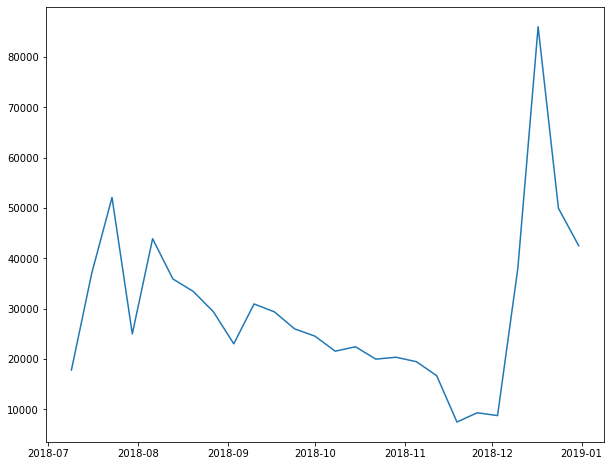

In [17]:
plt.plot(data_train.loc[(data_train['target']==0, 'date') ].value_counts().sort_index());

Посмотрим на количество подключений:

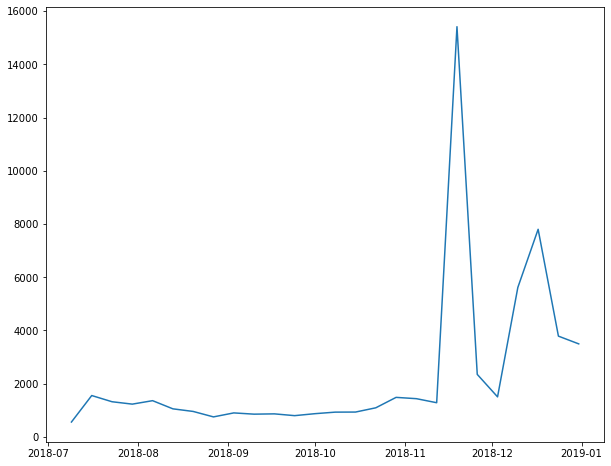

In [18]:
plt.plot(data_train.loc[(data_train['target']==1, 'date') ].value_counts().sort_index());

Смешанный график:

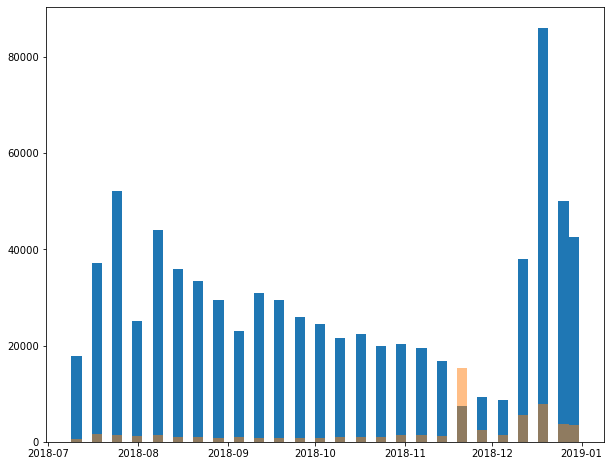

In [19]:
plt.hist(data_train.loc[(data_train['target']==0, 'date')], bins=50)
plt.hist(data_train.loc[(data_train['target']==1, 'date')], bins=50, alpha=0.5)
plt.show();

По этому графику видно, что в ноябре 2018 количество пользователей, которые приобрели предложенную услугу, оказалось намного больше, чем отказавшихся. Найдём этот день:

In [20]:
data_train.loc[(data_train['target']==1, 'date')].value_counts().head(1)

2018-11-19    15418
Name: date, dtype: int64

В дальнейшем следует удалить 19 ноября 2018 из выборки из-за сильной разницы с другими днями.

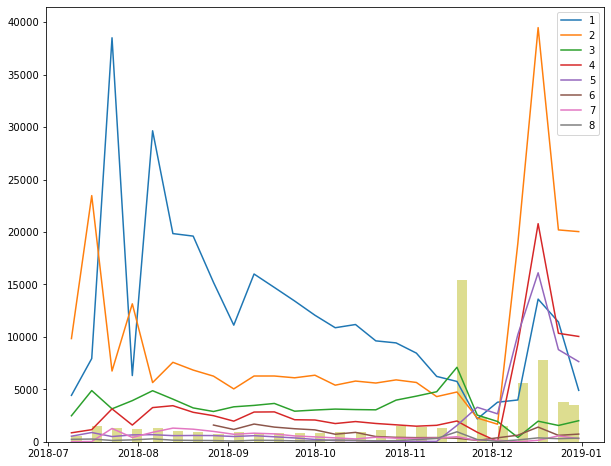

In [21]:
for p in sorted(list(data_train['vas_id'].unique())):
    plt.plot(data_train.loc[(data_train['vas_id']==p, 'date') ].value_counts().sort_index(), label=p)
plt.hist(data_train.loc[(data_train['target']==1, 'date') ], bins=50, alpha=0.5)
plt.legend()
plt.show();

По этому графику видим, что количество предложений по услугам 1 и 2 постепенно уменьшалось, но к середине декабря произошёл резкий скачок (вместе с услугами 4 и 5). Особенно сильно подскочила услуга № 2. Вероятно, такой скачок связан с новогодними праздниками, поскольку в этот период часто бывают акции. Услуги 3, 6, 7 и 8 такого эффекта не имели. Кроме того, к декабрю услуга № 3 пошла на спад по количеству предложений. Возможно, с начала ноября эту услугу подключило достаточное количество людей.

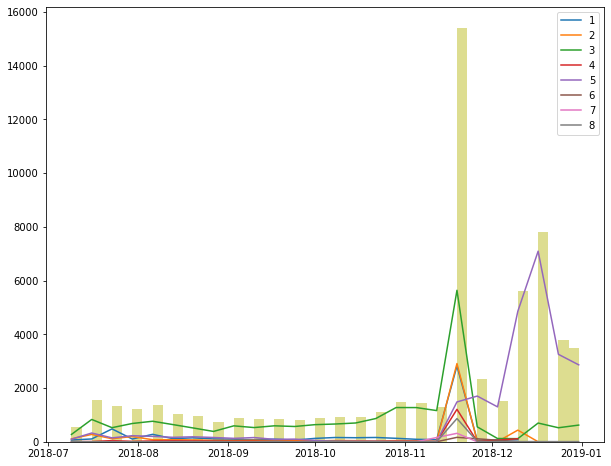

In [22]:
for p in sorted(list(data_train['vas_id'].unique())):
    plt.plot(data_train.loc[((data_train['vas_id']==p) & (data_train['target']==1), 'date') ].value_counts().sort_index(), label=p)
plt.hist(data_train.loc[(data_train['target']==1, 'date') ], bins=50, alpha=0.5)
plt.legend()
plt.show();

Видим, что лидерами по подключениям являются услуги 3 и 5. Действительно, услуга № 3 имела успех в ноябре, затем компания сделала акцент на других услугах перед новогодними праздниками, и уже в этот период самой эффективной оказалась услуга № 5. Кроме того, у услуги № 5 количество предложений практически совпадает с количеством подключений.

Посмотрим эти значения в цифрах:

In [23]:
data_train_0 = data_train.loc[(data_train['target']==0, 'vas_id')].value_counts().sort_index()
data_train_1 = data_train.loc[(data_train['target']==1, 'vas_id')].value_counts().sort_index()

data_train_01 = {
    'vas_id': [],
    '0': [],
    '1': []
}

data_train_01['vas_id'] = (list(data_train_0.index))
data_train_01['0'] = (list(data_train_0.values))
data_train_01['1'] = (list(data_train_1.values))

In [24]:
pd.DataFrame(data_train_01)

,vas_id,0,1
0,1,304511,5664
1,2,244708,4797
2,3,63991,21765
3,4,92393,1692
4,5,33174,24704
5,6,15219,213
6,7,13003,347
7,8,4468,1004


Относительные значения:

In [25]:
data_train_01_normalize = {
    'vas_id': [],
    '0': [],
    '1': []
}

for v_id in np.sort(data_train['vas_id'].unique()):
    data_train_01_normalize['vas_id'].append(v_id)
    data_train_0_normalize = data_train[data_train['vas_id'] == v_id]['target'].value_counts()[0] \
                             / len(data_train[data_train['vas_id'] == v_id]['target'])
    data_train_1_normalize = data_train[data_train['vas_id'] == v_id]['target'].value_counts()[1] \
                             / len(data_train[data_train['vas_id'] == v_id]['target'])
    data_train_01_normalize['0'].append(round(data_train_0_normalize, 2))
    data_train_01_normalize['1'].append(round(data_train_1_normalize, 2))

In [26]:
pd.DataFrame(data_train_01_normalize)

,vas_id,0,1
0,1,0.98,0.02
1,2,0.98,0.02
2,3,0.75,0.25
3,4,0.98,0.02
4,5,0.57,0.43
5,6,0.99,0.01
6,7,0.97,0.03
7,8,0.82,0.18


Удалим из выборки 19 ноября 2018, как и планировали ранее:

In [27]:
data_train = data_train[data_train['buy_time'] != int(datetime(2018, 11, 19).timestamp())]

Проверим графики ещё раз:

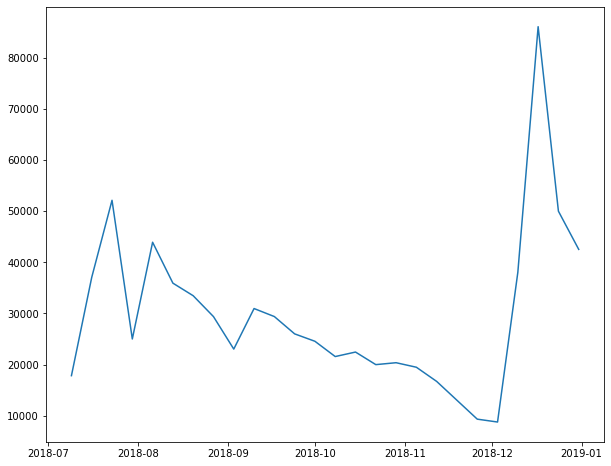

In [28]:
plt.plot(data_train.loc[(data_train['target']==0, 'date')].value_counts().sort_index());

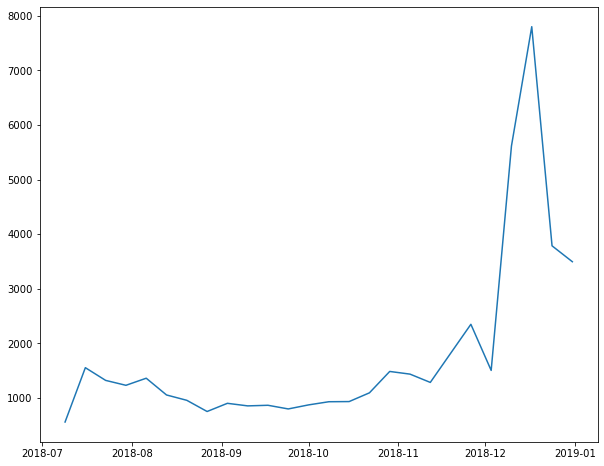

In [29]:
plt.plot(data_train.loc[(data_train['target']==1, 'date')].value_counts().sort_index());

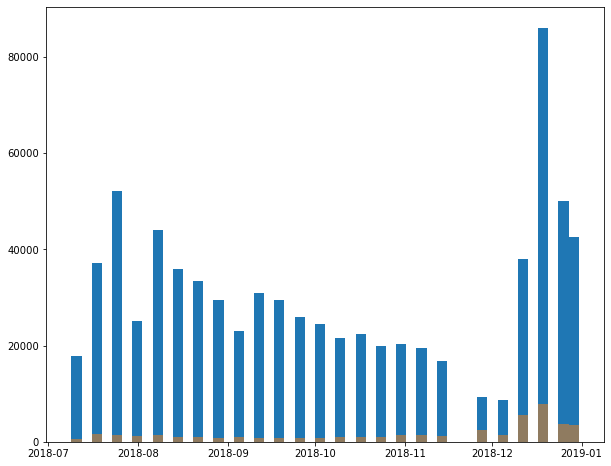

In [30]:
plt.hist(data_train.loc[(data_train['target']==0, 'date')], bins=50)
plt.hist(data_train.loc[(data_train['target']==1, 'date')], bins=50, alpha=0.5)
plt.show();

#### Объединение data_train с features

Сперва уберём из features тех пользователей, которых нет в data_train:

In [31]:
ids = data_train['id'].unique()
features = features.compute()
features = features.loc[(features['id'].isin(ids))]

In [32]:
features.head(4)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


Отсортируем датасеты по времени (признаку buy_time):

In [33]:
data_train = data_train.sort_index().sort_values(by='buy_time')

In [34]:
data_train.head(4)

,id,vas_id,buy_time,target,date
327202,2814496,2,1531083600,0.0,2018-07-09
339405,212196,4,1531083600,0.0,2018-07-09
440499,3929509,2,1531083600,0.0,2018-07-09
303275,2379697,2,1531083600,0.0,2018-07-09


In [35]:
features = features.sort_values(by='buy_time')

In [36]:
features.head(4)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
9426,1012743,1531083600,384.760029,74.650888,370.819214,22.043202,365.401754,0.93821,-13.34618,-62.336097,...,469.626154,-613.770792,110.003731,-37.630448,-136.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
146,1865910,1531083600,-12.169971,-136.499112,-26.110786,-108.596798,-31.528246,-129.70179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
8940,2880246,1531083600,-96.799971,222.750888,-66.240786,270.973202,-71.658246,249.86821,-16.08618,-65.076097,...,-249.373846,-82.770792,-23.996269,-37.630448,-274.747724,113.167111,-0.694428,126.824067,-0.45614,0.0
7255,1661200,1531083600,390.500029,290.980888,392.659214,257.613202,387.241754,236.50821,259.35382,210.363903,...,-580.373846,-609.770792,-25.996269,98.369552,758.252276,-18.832889,-0.694428,-5.175933,-0.45614,0.0


Важно, чтобы в датасете features были строки с пользователями, у которых дата либо меньше, либо равна аналогичному пользователю из датасета data_train.

Затем объединим датасеты по id пользователей:

In [37]:
train_data = pd.merge_asof(data_train, features, on='buy_time', by='id', direction='nearest')

Добавим в датасет train_data 3 новых признака (день, неделю и месяц):

In [38]:
train_data['day'] = train_data['date'].apply(lambda x: pd.to_datetime(x).day)
train_data['week'] = train_data['date'].apply(lambda x: pd.to_datetime(x).day // 7)
train_data['month'] = train_data['date'].apply(lambda x: pd.to_datetime(x).month)

Удалим признаки buy_time и date:

In [39]:
train_data = train_data.drop('buy_time', axis=1)
train_data = train_data.drop('date', axis=1)

Конвертируем признаки типа float64 в тип float32, чтобы уменьшить вес датасета:

In [40]:
train_data[train_data.select_dtypes(np.float64).columns] = train_data.select_dtypes(np.float64).astype(np.float32)

In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808738 entries, 0 to 808737
Columns: 259 entries, id to month
dtypes: float32(254), int64(5)
memory usage: 820.6 MB


In [42]:
train_data.head(4)

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,day,week,month
0,2814496,2,0.0,-96.799973,430.990875,-110.740784,378.383209,-116.158249,357.278198,-16.08618,...,-37.630447,-291.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,9,1,7
1,212196,4,0.0,-96.799973,7.070888,-110.740784,-45.536797,-116.158249,-66.641792,-16.08618,...,-37.630447,-195.747726,-24.832888,-0.694429,-11.175933,-0.45614,0.0,9,1,7
2,3929509,2,0.0,-56.129971,164.690887,10.429214,1116.273193,5.011754,1095.168213,24.58382,...,-37.630447,-302.747711,-24.832888,-0.694429,-11.175933,-0.45614,0.0,9,1,7
3,2379697,2,0.0,-96.799973,100.290886,-110.740784,47.683201,-116.158249,26.578211,-16.08618,...,-37.630447,-220.747726,-22.832888,-0.694429,-10.175933,-0.45614,0.0,9,1,7


Сохраним в csv-файле полученный датасет train_data:

In [43]:
train_data.to_csv('train_data_features.csv', index=False)

#### Обработка data_test

По аналогии с data_train обработаем и тестовый датасет:

In [44]:
data_test = pd.read_csv('data_test.csv')
data_test = data_test.drop('Unnamed: 0', axis=1)

data_test['date'] = data_test['buy_time'].apply(lambda x: date.fromtimestamp(x))

ids_dict = {1.0: 1, 2.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8}
data_test['vas_id'] = data_test['vas_id'].map(ids_dict)

In [45]:
data_test.head(4)

,id,vas_id,buy_time,date
0,3130519,2,1548018000,2019-01-21
1,2000860,3,1548018000,2019-01-21
2,1099444,2,1546808400,2019-01-07
3,1343255,4,1547413200,2019-01-14


In [46]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        71231 non-null  int64 
 1   vas_id    71231 non-null  int64 
 2   buy_time  71231 non-null  int64 
 3   date      71231 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.2+ MB


Видим, что пропущенных значений нет.

In [47]:
features_test = dd.read_csv('D:/megafon/project/features.csv', sep='\t')
features_test = features_test.drop('Unnamed: 0', axis=1)

ids_test = data_test['id'].unique()
features_test = features_test.compute()
features_test = features_test.loc[(features_test['id'].isin(ids_test))]

data_test = data_test.sort_index().sort_values(by='buy_time')
features_test = features_test.sort_values(by='buy_time')

test_data = pd.merge_asof(data_test, features_test, on='buy_time', by='id', direction='nearest')

test_data['day'] = test_data['date'].apply(lambda x: pd.to_datetime(x).day)
test_data['week'] = test_data['date'].apply(lambda x: pd.to_datetime(x).day // 7)
test_data['month'] = test_data['date'].apply(lambda x: pd.to_datetime(x).month)

test_data = test_data.drop('buy_time', axis=1)
test_data = test_data.drop('date', axis=1)

test_data[test_data.select_dtypes(np.float64).columns] = test_data.select_dtypes(np.float64).astype(np.float32)

In [48]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71231 entries, 0 to 71230
Columns: 258 entries, id to month
dtypes: float32(253), int64(5)
memory usage: 72.0 MB


In [49]:
test_data.head(4)

,id,vas_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,day,week,month
0,2905850,4,326.930023,227.410889,312.989227,200.223206,307.571747,179.118210,-16.08618,-65.076096,...,-18.630449,-209.747726,-15.832889,-0.694429,-2.175933,-0.45614,0.0,7,1,1
1,31619,2,-96.799973,100.290886,-62.040787,250.953201,-67.458244,229.848206,-16.08618,-65.076096,...,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,7,1,1
2,1427271,5,-87.299973,-368.999115,339.439209,48.733200,334.021759,27.628210,-16.08618,-65.076096,...,-37.630447,116.252274,25.167112,-0.694429,38.824066,-0.45614,0.0,7,1,1
3,2162521,5,-96.799973,-20.459112,-110.740784,-34.936798,-116.158249,-56.041790,-16.08618,-65.076096,...,-37.630447,-298.747711,-24.832888,-0.694429,-11.175933,-0.45614,0.0,7,1,1


Сохраним в csv-файле полученный датасет test_data:

In [50]:
test_data.to_csv('test_data_features.csv', index=False)